Accepted values for nitrous oxide properties from NIST CHEMICAL WEBBOOK: https://webbook.nist.gov/cgi/fluid.cgi?T=284&PLow=4.5&PHigh=4.5005&PInc=.0001&Digits=5&ID=C10024972&Action=Load&Type=IsoTherm&TUnit=K&PUnit=MPa&DUnit=kg%2Fm3&HUnit=kJ%2Fmol&WUnit=m%2Fs&VisUnit=uPa*s&STUnit=N%2Fm&RefState=DEF

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from thermo import Chemical
from thermo.eos import PR
import CoolProp.CoolProp as CP

# Global Constants:
R_U = 8.31446 #J/(mol K)
n2o_g = Chemical('nitrous oxide', T=298.15)
PC = n2o_g.Pc
TC = n2o_g.Tc
OMEGA = n2o_g.omega

MW = (n2o_g.MW/1000) #n2o.MW in g/mol --> converted to kg/mol
R_GAS_CONST = R_U/MW
KAPPA = 0.37464 + 1.5422*n2o_g.omega - 0.26992*n2o_g.omega**2
b = 0.07780*(R_U*TC/PC)
g = 9.81 #m/s^2

P_atm = 101325

print("imported libraries")

imported libraries


Check 1: Compare cp ideal gas properties between Chemical and [7] Glenn Polynomial

In [15]:
def T_sat_polynomial(P):
    A = 4.80716087
    B = 967.819748
    C = 19.6368887

    T_sat = B/(A -np.log10( P/100000) ) - C
    # Apply temperature limits
    if 140 < T_sat and T_sat < 310:
        return T_sat
    raise ValueError("Temperature outside of function bounds!")

P_arr = np.linspace(3.5e6, 5.5e6, 20)
poly_t_sat_arr = []
cool_tsat_arr = []
preos_tsat_arr = []


for P in P_arr:

    poly_t_sat_arr.append( T_sat_polynomial(P) )
    cool_tsat_arr.append( CP.PropsSI('T', 'P', P, 'Q', 0, 'N2O') )
    preos_g = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_REF, P=P)
    preos_tsat_arr.append( preos_g.Tsat(P) )



plt.scatter(P_arr, poly_t_sat_arr, label = "polynomial", color = 'orchid')
plt.scatter(P_arr, cool_tsat_arr, label = "coolprop", color = 'darkslateblue')
plt.scatter(P_arr, preos_tsat_arr, label = "preos", color = 'dodgerblue')
plt.xlabel('Pressure (Pa)')
plt.ylabel('Tsat (K)')
plt.title('Saturation Temperature vs Pressure for Check 6.1')
plt.legend()
plt.grid(True)
plt.show()

    

NameError: name 'T_REF' is not defined

In [ ]:
def solve_cp_ig_polynomial(T):
    A = 21.62
    B = 72.81
    C = -57.78
    D = 18.3
    E = 0.0
    if 150<T and T<310:
        T_reduced = T/1000

        #NOTE: Thesis has this multiplied by a factor of 1000, but I think that is to convert MW because otherwise magnitude seems 1000x too big
        cp = (A + B*T_reduced + C*T_reduced**2 + D*T_reduced**3 + E/(T_reduced**2) ) / MW

        return cp #J/(kg K)
    raise ValueError("Temperature outside of function bounds!")


P_arr = np.linspace(270, 305, (305-270) )

cp_chemical_arr = []
cp_polynomial_arr = []


for T in temp_arr:
    n2o_ig_for_cp = Chemical('N2O', T=T, P= 4e6) 
    cp_chemical_arr.append( n2o_ig_for_cp.Cpg )
    cp_polynomial_arr.append( solve_cp_ig_polynomial(T) )


plt.scatter(temp_arr, cp_chemical_arr, label = "chemical library")
plt.scatter(temp_arr, cp_polynomial_arr, label = "ig polynomial")
plt.xlabel('Temp (T)')
plt.ylabel('Cp (J/(kg K))')
plt.title('IDEAL GAS Cp vs. Temperature for Check 1')
plt.legend()
plt.grid(True)
plt.show()

Check 2.1: Compare real gas cp with (ig + PR_ref) to NIST cp
- Where NIST cp taken at P = 1 atm from 270K to 305K (entirely vapor phase)

In [ ]:
P_step_2 = 101325 #Pa

temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
cp_real_NIST_const_P_arr = [855.6,857.59,859.57,861.55,863.53,865.5,867.46,869.42,871.37,873.32,875.27,877.2,879.13,881.06,882.97,884.88,886.79,888.69,890.58,]
cp_solve_arr = []

for T in temp_arr:
    n2o_ig_step_2= Chemical('N2O', T=T, P= P_atm) 
    preos_g_step_2 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, P=P_step_2)
    cp_solve_arr.append( (preos_g_step_2.Cp_dep_g/MW + n2o_ig_step_2.Cpg) )
    
plt.scatter(temp_arr, cp_real_NIST_const_P_arr, label = "NIST", color = 'r')
plt.scatter(temp_arr, cp_solve_arr, label = "ig polynomial + dep", color = 'g')
plt.xlabel('Temp (T)')
plt.ylabel('Cp (J/(kg K))')
plt.title('REAL GAS Cp vs. Temperature for Check 2.1')
plt.legend()
plt.grid(True)
plt.show()


Check 2.2: Compare real gas cp with (ig + PR_ref) to NIST cp
- Where NIST cp taken at P = 4 MPa from 270K to 305K (partially liq and vapor)
changes from liq (T= 283.14 K, cp= 2567.3 J/(kg K)) --> vap (T= 283.14 K, cp= 2133.9 J/(kg K)) 


In [ ]:
P_step_2 = 4e6 #Pa

temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
cp_real_NIST_const_P_arr = [2153.2,2193.2,2238.6,2290.7,2351.3,2423,2509.5,2065.4,1933,1827.8,1742.1,1670.9,1610.8,1559.4,1515,1476.3,1442.2,1412.1,1385.2]

cp_solve_g_arr = []
cp_solve_l_arr = []
T_g_arr = []
T_l_arr = []

T_transition = 283.14


for T in temp_arr:
    n2o_ig_step_2= Chemical('N2O', T=T, P= P_step_2) 
    preos_step_2 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, P=P_step_2)
    

    if T > T_transition:
        cp_solve_g_arr.append( (preos_g_step_2.Cp_dep_g/MW + n2o_ig_step_2.Cpg) )

        print("for gas property: dep / ig: ", (preos_g_step_2.Cp_dep_g/MW, n2o_ig_step_2.Cpg))
        T_g_arr.append(T)

    else: 
        cp_solve_l_arr.append( (preos_step_2.Cp_dep_l/MW + n2o_ig_step_2.Cpg) )
        T_l_arr.append(T)
    
plt.scatter(temp_arr, cp_real_NIST_const_P_arr, label = "NIST", color = 'r')
plt.scatter(T_g_arr, cp_solve_g_arr, label = "ig polynomial + dep gas", color = 'orchid')
plt.scatter(T_l_arr, cp_solve_l_arr, label = "ig polynomial + dep liquid", color = 'darkslateblue')

plt.axvline(T_transition)
plt.xlabel('Temp (T)')
plt.ylabel('Cp (J/(kg K))')
plt.title('REAL GAS Cp vs. Temperature for Check 2.2')
plt.legend()
plt.grid(True)
plt.show()

Check 3.1: Compare cv ideal gas properties between Chemical and [7] Glenn Polynomial
(note for ideal gas Cp - Cv = R_GAS_Const )

In [ ]:
def solve_cv_ig_polynomial(T):
    A = 21.62
    B = 72.81
    C = -57.78
    D = 18.3
    E = 0.0
    if 150<T and T<310:
        T_reduced = T/1000

        #NOTE: Thesis has this multiplied by a factor of 1000, but I think that is to convert MW because otherwise magnitude seems 1000x too big
        cp = (A + B*T_reduced + C*T_reduced**2 + D*T_reduced**3 + E/(T_reduced**2) ) / MW
        cv = cp - R_GAS_CONST
        return cv #J/(kg K)
    raise ValueError("Temperature outside of function bounds!")


temp_arr = np.linspace(270, 305, (305-270) )

cv_chemical_arr = []
cv_polynomial_arr = []


for T in temp_arr:
    n2o_ig_for_cv = Chemical('N2O', T=T, P= 4e6) 
    cv_chemical_arr.append( n2o_ig_for_cv.Cvg )
    cv_polynomial_arr.append( solve_cv_ig_polynomial(T) )


plt.scatter(temp_arr, cv_chemical_arr, label = "chemical library")
plt.scatter(temp_arr, cv_polynomial_arr, label = "ig polynomial")
plt.xlabel('Temp (T)')
plt.ylabel('Cv (J/(kg K))')
plt.title('IDEAL GAS Cv vs. Temperature for Check 3')
plt.legend()
plt.grid(True)
plt.show()

Check 3.2: Compare real gas cv with (ig + PR_ref) to NIST cv
- Where NIST cv taken at P = 4 MPa from 270K to 305K (partially liq and vapor)
changes from liq (T= 283.14 K, cv= 916.95 J/(kg K)) --> vap (T= 283.14 K, cv= 923.2 J/(kg K)) 

In [ ]:
P_step_2 = P_atm #Pa

temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
cv_real_NIST_const_P_arr = [909.36,909.82,910.45,911.3,912.4,913.83,915.67,914.02,895.29,879.49,866.05,854.53,844.6,836.01,828.56,822.08,816.42,811.49,807.19,]

cv_solve_g_arr = []
cv_solve_l_arr = []
T_g_arr = []
T_l_arr = []

T_transition = 283.14


for T in temp_arr:
    n2o_ig_step_2= Chemical('N2O', T=T, P= P_step_2) 
    preos_step_2 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, P=P_step_2)
    

    if T > T_transition:
        cv_solve_g_arr.append( (preos_g_step_2.Cv_dep_g/MW + n2o_ig_step_2.Cvg) )

        #print("for gas property: dep / ig: ", (preos_g_step_2.Cv_dep_g/MW, n2o_ig_step_2.Cvg))
        T_g_arr.append(T)

    else: 
        cv_solve_l_arr.append( (preos_step_2.Cv_dep_l/MW + n2o_ig_step_2.Cvg) )
        T_l_arr.append(T)
    
plt.scatter(temp_arr, cv_real_NIST_const_P_arr, label = "NIST", color = 'r')
plt.scatter(T_g_arr, cv_solve_g_arr, label = "ig polynomial + dep gas", color = 'orchid')
plt.scatter(T_l_arr, cv_solve_l_arr, label = "ig polynomial + dep liquid", color = 'darkslateblue')

plt.axvline(T_transition)
plt.xlabel('Temp (T)')
plt.ylabel('Cv (J/(kg K))')
plt.title('REAL GAS Cv vs. Temperature for Check 2.2')
plt.legend()
plt.grid(True)
plt.show()

Check 4.1: Want to compare Chemical ideal gas enthalpy --> need to integrate cp polynomial to solve ideal gas enthalpy!

NOTE: CHEMICAL LIB USES T = 298.15 K, P = 101325 Pa AS REF STATE!

NOTE: IT SEEMS LIKE THE "IDEAL GAS ENTHALPY" FROM THE CHEMICAL LIB IS SENSITIVE TO CHANGES IN INPUT PRESSURE, AND DOES NOT SEEM TO REFLECT IDEAL GAS ENTHALPY!
THIS IS LIKELY A MISUSE, I SHOULD LIKELY USE THE POLYNOMIALS FOR IDEAL GAS!!!

In [ ]:
def solve_cp_ig_polynomial(T):
    # Polynomial coefficients
    A = 21.62
    B = 72.81
    C = -57.78  
    D = 18.3
    E = 0.0

    # Apply temperature limits
    if 150 < T and T < 310:
        T_reduced = T / 1000
        cp = (A + B * T_reduced + C * T_reduced**2 + D * T_reduced**3 + E / (T_reduced**2)) / MW  # J/(kg K)
        return cp
    raise ValueError("Temperature outside of function bounds!")

def integrate_polynomial_ig_enthalpy(T_REF, T):
    N = 1000  # Number of intervals for numerical integration
    dt = (T - T_REF) / N
    integral = 0
    for i in range(N):
        Ti = T_REF + i * dt
        Ti_next = Ti + dt
        # Midpoint for integration
        integral += solve_cp_ig_polynomial((Ti + Ti_next) / 2) * dt
    return integral


T_REF = 298.15  # Reference temperature (K)



temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
polynomial_trapezoid_ig_enthalpy =[]
chemical_lib_ig_enthalpy = []

for T in temp_arr:
    n2o_ig_check_4 = Chemical('N2O', T=T, P= 4e6) 
    chemical_lib_ig_enthalpy.append( n2o_ig_check_4.H )
    polynomial_trapezoid_ig_enthalpy.append( integrate_polynomial_ig_enthalpy(T_REF, T) )


plt.scatter(temp_arr, chemical_lib_ig_enthalpy, label = "chemical library")
plt.scatter(temp_arr, polynomial_trapezoid_ig_enthalpy, label = "ig polynomial")
plt.xlabel('Temp (T)')
plt.ylabel('h (J/kg)')
plt.title('IDEAL GAS Enthalpy vs. Temperature for Check 4')
plt.legend()
plt.grid(True)
plt.show()




Check 4.2: Want to compare REAL FLUID ENTHALPY, so using ideal gas enthalpy + PR EOS departure enthalpy and comparing to NIST VALUES!!!
- Where NIST cv taken at P = 4 MPa from 270K to 305K (partially liq and vapor)
changes from liq (T= 283.14 K, h= 188.57 kJ/kg) --> vap (T= 283.14 K, h= 393.50 kJ/kg) 

NOTE: NIST ENTHALPY CONVENTION IS THE NORMAL BOILING POINT:

T_boiling = 182.5K for nitrous oxide

NOTE: IT SEEMS LIKE THE "IDEAL GAS ENTHALPY" FROM THE CHEMICAL LIB IS SENSITIVE TO CHANGES IN INPUT PRESSURE, AND DOES NOT SEEM TO REFLECT IDEAL GAS ENTHALPY!
THIS IS LIKELY A MISUSE, I SHOULD LIKELY USE THE POLYNOMIALS FOR IDEAL GAS!!!

In [ ]:
P_step_4 = 4e6 #Pa

NIST_enthalpy_arr = [158030.0, 162380.0, 166810.0, 171340.0, 175980.0, 180750.0, 185680.0, 395310.0, 399300.0, 403060.0, 406630.0, 410040.0, 413320.0, 416490.0, 419560.0, 422550.0, 425470.0, 428320.0, 431120.0]

temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]

ig_dep_enthalpy_l_arr =[]
ig_dep_enthalpy_g_arr =[]

T_g_arr = []
T_l_arr = []

T_BOIL = 182.5

T_transition = 283.14
n2o_ig_ref= Chemical('N2O', T=T_BOIL, P= P_atm) 
n2o_ref_convers = n2o_ig_ref.H


for T in temp_arr:
    n2o_ig_step_4= Chemical('N2O', T=T, P= P_step_4) 
    preos_step_4 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, P=P_step_4)
    

    if T > T_transition:
        ig_dep_enthalpy_g_arr.append( (preos_step_4.H_dep_g/MW + n2o_ig_step_4.H - n2o_ref_convers) )
        T_g_arr.append(T)
        print( "debugging gas: ", preos_step_4.phase, (preos_step_4.H_dep_g/MW + n2o_ig_step_4.H - n2o_ref_convers), preos_step_4.H_dep_g/MW , n2o_ig_step_4.H, - n2o_ref_convers)

    else: 
        #ig_dep_enthalpy_l_arr.append( (preos_step_4.h_dep_l/MW + n2o_ig_step_4.H) )
        ig_dep_enthalpy_l_arr.append( (preos_step_4.H_dep_l/MW + n2o_ig_step_4.H + preos_step_4.Hvap(T_REF)/MW) )
        T_l_arr.append(T)
        print( "debugging liquid: ", preos_step_4.phase, (preos_step_4.H_dep_l/MW + n2o_ig_step_4.H - n2o_ref_convers), preos_step_4.H_dep_l/MW , n2o_ig_step_4.H, preos_step_4.Hvap(T_REF)/MW) 
    
plt.scatter(temp_arr, NIST_enthalpy_arr, label = "NIST", color = 'r')
plt.scatter(T_g_arr, ig_dep_enthalpy_g_arr, label = "ig polynomial + dep gas", color = 'orchid')
plt.scatter(T_l_arr, ig_dep_enthalpy_l_arr, label = "ig polynomial + dep liquid", color = 'darkslateblue')

plt.axvline(T_transition)
plt.xlabel('Temp (T)')
plt.ylabel('h (J/kg)')
plt.title('REAL GAS h vs. Temperature for Check 2.2')
plt.legend()
plt.grid(True)
plt.show()

Check 4.3: Compare numerical vs analytical integration for enthalpy

In [ ]:
def solve_cp_ig_polynomial(T):
    # Polynomial coefficients
    A = 21.62
    B = 72.81
    C = -57.78  
    D = 18.3
    E = 0.0

    # Apply temperature limits
    if 150 < T and T < 310:
        T_reduced = T / 1000
        cp = (A + B * T_reduced + C * T_reduced**2 + D * T_reduced**3 + E / (T_reduced**2)) / MW  # J/(kg K) - from [7] but modified because my MW in terms of kg not g
        return cp
    raise ValueError("Temperature outside of function bounds!")

def numerical_integration_cp_poly_ig_enthalpy(T_REF, T):
    N = 1000  # Number of intervals for numerical integration
    dt = (T - T_REF) / N
    integral = 0
    for i in range(N):
        Ti = T_REF + i * dt
        Ti_next = Ti + dt
        # Midpoint for integration
        integral += solve_cp_ig_polynomial((Ti + Ti_next) / 2) * dt
    return integral


def analytical_integration_cp_poly_ig_enthalpy(T_REF, T):
    # Polynomial coefficients
    A = 21.62
    B = 72.81
    C = -57.78  
    D = 18.3
    E = 0.0

    # Apply temperature limits
    if 150 < T and T < 310:
        h = (T*( (12E16)*E - T_REF**2*( (12E10)*A + (6E6)*B*T_REF + (4E3)*C*T_REF**2 + 3*D*T_REF**3)) + T_REF*(-(12E16)*E + T**2*( (12E10)*A + (6E6)*B*T + (4E3)*C*T**2 + 3*D*T**3)))/( (12E10)*MW*T*T_REF)
        h = (T*(12000000000000000*E - T_REF**2*(12000000000*A + 6000000*B*T_REF + 4000*C*T_REF**2 + 3*D*T_REF**3)) + T_REF*(-12000000000000000*E + T**2*(12000000000*A + 6000000*B*T + 4000*C*T**2 + 3*D*T**3)))/(12000000000*MW*T*T_REF)
        return h
    raise ValueError("Temperature outside of function bounds!")

temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
h_numerical_arr = []
h_analytical_arr = []


for T in temp_arr:

    h_numerical_arr.append( numerical_integration_cp_poly_ig_enthalpy(T_REF, T) )
    h_analytical_arr.append( analytical_integration_cp_poly_ig_enthalpy(T_REF, T) )
        

plt.scatter(temp_arr, h_numerical_arr, label = "numerical", color = 'orchid')
plt.scatter(temp_arr, h_analytical_arr, label = "analytical", color = 'darkslateblue')

plt.xlabel('Temp (T)')
plt.ylabel('h (J/kg)')
plt.title('REAL GAS h vs. Temperature for Check 2.2')
plt.legend()
plt.grid(True)
plt.show()



ANALYTICAL ENTHALPY MATCHES NUMERICAL ENTHALPY

Check 5.1: matching numerical and analytical ideal gas internal energy

In [ ]:
def solve_cp_ig_polynomial(T):
    # Polynomial coefficients
    A = 21.62
    B = 72.81
    C = -57.78  
    D = 18.3
    E = 0.0

    # Apply temperature limits
    if 150 < T and T < 310:
        T_reduced = T / 1000
        cp = (A + B * T_reduced + C * T_reduced**2 + D * T_reduced**3 + E / (T_reduced**2)) / MW  # J/(kg K)
        return cp
    raise ValueError("Temperature outside of function bounds!")

def numerical_integration_cp_poly_ig_enthalpy(T_REF, T):
    N = 1000  # Number of intervals for numerical integration
    dt = (T - T_REF) / N
    integral = 0
    for i in range(N):
        Ti = T_REF + i * dt
        Ti_next = Ti + dt
        # Midpoint for integration
        integral += solve_cp_ig_polynomial((Ti + Ti_next) / 2) * dt
    return integral


def analytical_integration_cp_poly_ig_enthalpy(T_REF, T):
    # Polynomial coefficients
    A = 21.62
    B = 72.81
    C = -57.78  
    D = 18.3
    E = 0.0

    # Apply temperature limits
    if 150 < T and T < 310:
        h_ig = (T*(12000000000000000*E - T_REF**2*(12000000000*A + 6000000*B*T_REF + 4000*C*T_REF**2 + 3*D*T_REF**3)) + T_REF*(-12000000000000000*E + T**2*(12000000000*A + 6000000*B*T + 4000*C*T**2 + 3*D*T**3)))/(12000000000*MW*T*T_REF)
        return h_ig
    raise ValueError("Temperature outside of function bounds!")

"""
NOTE: messed up here:
def analytical_integration_internal_energy(T_ref, T):
        # Polynomial coefficients
        A = 21.62
        B = 72.81
        C = -57.78  
        D = 18.3
        E = 0.0

        u_ig =(T*(12000000000000000*E - T_ref**2*(12000000000*A + 6000000*B*T_ref + 4000*C*T_ref**2 + 3*D*T_ref**3 - 12000000000*R_U)) + T_ref*(-12000000000000000*E + T**2*(12000000000*A + 6000000*B*T + 4000*C*T**2 + 3*D*T**3 - 12000000000*R_U)))/(12000000000*(1000*MW)*T*T_ref)
        return u_ig
"""

def numerical_integration_cp_poly_ig_int_energy(T_REF, T):
    u_ig = numerical_integration_cp_poly_ig_enthalpy(T_REF, T) - R_U*T
    return u_ig

def analytical_integration_cp_poly_ig_int_energy(T_REF, T):
    u_ig = analytical_integration_cp_poly_ig_enthalpy(T_REF, T) - R_U*T
    return u_ig



temp_arr = [270,272,274,276,278,280,282,284,286,288,290,292,294,296,298,300,302,304,306]
h_numerical_arr = []
h_analytical_arr = []


for T in temp_arr:

    h_numerical_arr.append( numerical_integration_cp_poly_ig_int_energy(T_REF, T) )
    h_analytical_arr.append( analytical_integration_internal_energy(T_REF, T) )
        

plt.scatter(temp_arr, h_numerical_arr, label = "numerical", color = 'orchid')
plt.scatter(temp_arr, h_analytical_arr, label = "analytical", color = 'darkslateblue')

plt.xlabel('Temp (T)')
plt.ylabel('u (J/kg)')
plt.title('REAL GAS u vs. Temperature for Check 5.1')
plt.legend()
plt.grid(True)
plt.show()

Check 6.1: Comparing T_sat between preos library obj and polynomial!

In [ ]:
def T_sat_polynomial(P):
    A = 4.80716087
    B = 967.819748
    C = 19.6368887

    T_sat = B/(A -np.log10( P/100000) ) - C
    # Apply temperature limits
    if 140 < T and T < 310:
        return T_sat
    raise ValueError("Temperature outside of function bounds!")

P_arr = np.linspace(3.5e6, 5.5e6, 20)
poly_t_sat_arr = []
cool_tsat_arr = []
preos_tsat_arr = []


for P in P_arr:

    poly_t_sat_arr.append( T_sat_polynomial(P) )
    cool_tsat_arr.append( CP.PropsSI('T', 'P', P, 'Q', 0, 'N2O') )
    preos_g = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_REF, P=P)
    preos_tsat_arr.append( preos_g.Tsat(P) )



plt.scatter(P_arr, poly_t_sat_arr, label = "polynomial", color = 'orchid')
plt.scatter(P_arr, cool_tsat_arr, label = "coolprop", color = 'darkslateblue')
plt.scatter(P_arr, preos_tsat_arr, label = "preos", color = 'dodgerblue')
plt.xlabel('Pressure (Pa)')
plt.ylabel('Tsat (K)')
plt.title('Saturation Temperature vs Pressure for Check 6.1')
plt.legend()
plt.grid(True)
plt.show()

    

Check 7.1 --> du/drho|T for liquid: 

In [ ]:
def analytical_integration_cp_poly_ig_enthalpy(T_REF, T):
    # Polynomial coefficients
    A = 21.62
    B = 72.81
    C = -57.78  
    D = 18.3
    E = 0.0

    # Apply temperature limits
    if 150 < T and T < 310:
        h_ig = (T*(12000000000000000*E - T_REF**2*(12000000000*A + 6000000*B*T_REF + 4000*C*T_REF**2 + 3*D*T_REF**3)) + T_REF*(-12000000000000000*E + T**2*(12000000000*A + 6000000*B*T + 4000*C*T**2 + 3*D*T**3)))/(12000000000*MW*T*T_REF)
        return h_ig
    raise ValueError("Temperature outside of function bounds!")


def analytical_integration_cp_poly_ig_int_energy(T_REF, T):
    u_ig = analytical_integration_cp_poly_ig_enthalpy(T_REF, T) - R_U*T
    return u_ig


def solve_du_drho_const_T_liq(rho,T,P):

    vm = 1/rho #multiply by MW when using SI
    print(vm)


    preos_l = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, P=P)

    
    sqrt_two = np.sqrt(2)
    #solve a_alpha
    a_alpha = preos_l.a_alpha_pure(T)

    #if this fails try w gas constant instead of R_U
    dA_dV_const_T_l_dep = ( (R_U*T)/(vm) ) + ( (R_U*T)/(vm - b) ) - (a_alpha /( 2*sqrt_two*b) )*( (1/(vm+(1+sqrt_two)*b)) - (1/(vm+(1-sqrt_two)*b)) )

    du_dvm_const_T_l_dep = dA_dV_const_T_l_dep + P + vm*preos_l.dP_dV_l

    #convert to du_drho_const_T
    du_drho_const_T_l_dep =  (-MW)/(rho**2)*(du_dvm_const_T_l_dep)

    du_drho_const_T_l = du_drho_const_T_l_dep
    
    #du_drho_const_T_l  = preos_l.dH_dep_dV_l_T -P -vm*preos_l.dP_dV_l

    #print("checking du_drho_constT_l", du_drho_const_T_l)
    #print("checking deriv 1 and 2: ", du_drho_const_T_l, testing_deriv_second_way)

    return du_drho_const_T_l


T_REF = 200

###From NIST:
T_NIST = 284 #K
rho_NIST_0 = 852.087084084 # kg/m^3
P_NIST = 4.5e6

vm_0 = MW/rho_NIST_0 
preos_l_0 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_NIST, V= vm_0)
P_0 = preos_l_0.P

u_ig_0 = analytical_integration_cp_poly_ig_int_energy(T_REF, T_NIST)
u_dep_0 = preos_l_0.U_dep_l
u_0 = u_ig_0 + u_dep_0/MW

delta_rho = 0.0001 #kg/m^3
rho_1 = rho_NIST_0 + delta_rho

vm_1 = MW/rho_1
preos_l_1 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_NIST, V= vm_1)
P_1 = preos_l_1.P

u_ig_1 = analytical_integration_cp_poly_ig_int_energy(T_REF, T_NIST)
u_dep_1 = preos_l_1.U_dep_l
u_1 = u_ig_1 + u_dep_1/MW

def solve_du_drho_const_T_liq_central_differences(T, rho, delta_rho):
    # my bad guys i kept messing up the calculus
    rho_0 = rho - delta_rho
    vm_0 = MW/rho_0 
    preos_l_0 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, V= vm_0)
    P_0 = preos_l_0.P
    u_dep_0 = preos_l_0.U_dep_l

    rho_1 = rho + delta_rho
    vm_1 = MW/rho_1
    preos_l_1 = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, V= vm_1)
    P_1 = preos_l_1.P
    u_dep_1 = preos_l_1.U_dep_l

    print("pressures check: ", P_1, P_0)
    central_difference_du_drho_const_T =  ( (u_dep_1/MW) - (u_dep_0/MW) ) / (rho_1-rho_0) #since u_ig = f(T) only, the ideal gas component is the same so take difference in departure function
    return central_difference_du_drho_const_T

delta_rho = 0.0001 #kg/m^3
central_diff_du_drho_const_T = solve_du_drho_const_T_liq_central_differences(T_NIST, rho_NIST_0, delta_rho)


NIST_APPROX_du_drho_const_T =  (u_1-u_0) / (rho_1-rho_NIST_0)


preos_du_drho_const_T = solve_du_drho_const_T_liq(rho_NIST_0,T_NIST,P_NIST)


print("numerical derivative vs central differences function for script vs my analytical derivative implementation: ", NIST_APPROX_du_drho_const_T, central_diff_du_drho_const_T, preos_du_drho_const_T)



Check 8: investigating T_sat --> SHOULD be the same between liq and gas preos objects but a lot of things SHOULD have worked a certain way so investigating

In [ ]:
P_tank = 4.5e6 #Pa

T_liq = 270.00 #K
T_gas = 300 #K 

preos_g = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_gas, P=P_tank)
T_sat_gas = preos_g.Tsat(P_tank)
    
preos_l = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_liq, P=P_tank)
T_sat_liq = preos_g.Tsat(P_tank)


print("these should be the same! ", T_sat_gas, T_sat_liq)

Now Problem is definitely with heat transfer!

Check 9: Viscosity

In [ ]:
T_arr = [270,274,278,282,286,290,294,298,302]
#cool_visc_arr =[] - coolprop does not have a viscosity model for this fluid
chem_visc_arr =[]

P_nist= 4.5e6 #Pa
T_transition = 288.114642545 #K

dyn_visc_nist_arr = [9.85058125277e-05,9.33041389475e-05,8.81023373672e-05,8.28183444560e-05,7.73265569736e-05,1.70451314821e-05,1.70638129150e-05,1.71190505970e-05,1.71974485219e-05] #Pa*s
rho_nist_arr = [933.782754682,912.927829134,890.386257968,865.597168019,837.606521862,129.734975611,122.312722828,116.411897939,111.500779097]

kinetic_visc_nist_arr = []
i = 0
while i < len(rho_nist_arr):
    kinetic_visc_nist_arr.append( dyn_visc_nist_arr[i]/rho_nist_arr[i]  )

    i +=1

T_crash_arr = []
try:
    for T in T_arr:
        n2o = Chemical('N2O', T=T, P=P_nist)

        if T > T_transition:
            visc_chem = n2o.nug

        else: 
            visc_chem = n2o.nul
        
        T_crash_arr.append(T)
        chem_visc_arr.append(visc_chem)


except Exception as e:
    print("error!")
    print(e)



plt.scatter(T_crash_arr, chem_visc_arr, label = "Chemical", color = 'orchid')
plt.scatter(T_arr, kinetic_visc_nist_arr, label = "nist", color = 'darkslateblue')
plt.ylabel('Latent Heat J/kg')
plt.xlabel('Tsat (K)')
plt.title('Saturation Temperature vs Pressure for Check 9')
plt.legend()
plt.grid(True)
plt.show()

Check 10: thermal conductivity

In [ ]:
T_arr = [270,274,278,282,286,290,294,298,302]
chem_k_arr =[]

P_nist= 4.5e6 #Pa
T_transition = 288.114642545 #K

thermal_cond_nist_arr = [0.107247765033,0.102612798679,0.0979223787298,0.0931493373211,0.0882517101678,0.0235887970424,0.0228998070686,0.0225525314362,0.0223934406808] # (W/(m*K))

T_crash_arr = []
try:
    for T in T_arr:
        n2o = Chemical('N2O', T=T, P=P_nist)

        if T > T_transition:
            k_chem = n2o.kg

        else: 
            k_chem = n2o.kl
        
        T_crash_arr.append(T)
        chem_k_arr.append(k_chem)


except Exception as e:
    print("error!")
    print(e)



plt.scatter(T_crash_arr, chem_k_arr, label = "Chemical", color = 'orchid')
plt.scatter(T_arr, thermal_cond_nist_arr, label = "nist", color = 'darkslateblue')
plt.ylabel('Thermal Conductivity W/(m K)')
plt.xlabel('T (K)')
plt.title('Thermal Conductivity Check')
plt.legend()
plt.grid(True)
plt.show()

11) Want to explore viscosity more: using polynomials from [7]

In [ ]:
from ..thermo_property_lookup.get_n2o_viscosity import get_n2o_viscosity

from thermo.eos import PR

def gas_dynamic_visc_polynomial(T):
    # Polynomial coefficients
    A = 2.1150E-6
    B = 0.46420
    C = 305.70
    D = 0.0

    # Apply temperature limits
    if 182 < T and T < 1000:
        dvisc = A*T**B / ( 1 + C/T + D/T**2)
        return dvisc
    raise ValueError("Temperature outside of function bounds!")

def liq_dynamic_visc_polynomial(T):
    # Polynomial coefficients
    A = 0.001877085
    B = 1.1864E-5
    C = 1.928E-8 

    # Apply temperature limits
    if 182 < T and T < 1000:
        dvisc = A + B*T + C*T**2
        return dvisc
    raise ValueError("Temperature outside of function bounds!")


P_nist= 4.5e6 #Pa
T_transition = 288.114642545 #K

T_arr = [270,274,278,282,286,290,294,298,302]

polynomial_arr = []

T_crash_arr = []
try:
    for T in T_arr:
        preos= PR(Tc=TC, Pc=PC, omega=OMEGA, T=T_liq, P=P_nist)
        
        if T > T_transition:
            dvisc = gas_dynamic_visc_polynomial(T) 
            kvisc = dvisc/(preos.rho_l*MW)

        else: 
            dvisc = liq_dynamic_visc_polynomial(T)
            kvisc = dvisc/(preos.rho_g*MW)
        
        T_crash_arr.append(T)
        chem_k_arr.append(k_chem)

except Exception as e:
    print("error!")
    print(e)





12) Check thesis h_lv polynomial against method I am currently using in thesis:

9 9 9


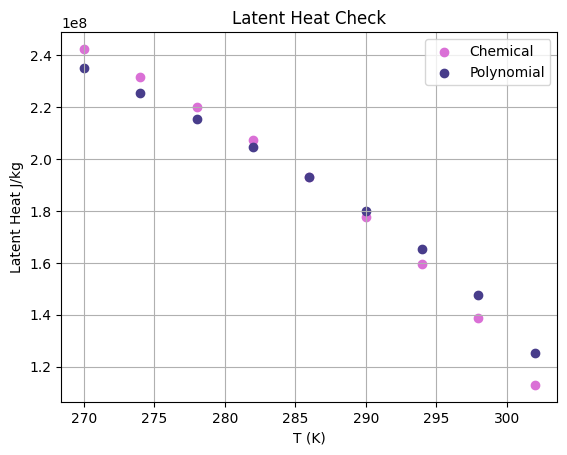

In [27]:

T_REF = 298.15 #K
n2o_g = Chemical('nitrous oxide', T=T_REF)
TC = n2o_g.Tc
MW = (n2o_g.MW/1000)

def h_latent_heat_polynomial(T):
    A = 2.686E7
    B = 0.182
    C = 0.9387
    D = -0.706
    E = 0.0

    # Apply temperature limits
    if 182 < T and T < 310:
        T_r = T/TC
        h_lv = ( A*(1-T_r)**(B + C*T_r +D*T_r**2 +E*T_r**3) )/MW
        return h_lv #J/kg
    raise ValueError("Temperature outside of function bounds!")



T_arr = [270,274,278,282,286,290,294,298,302]

P_nist= 4.5e6 #Pa

polynomial_arr = []
preos_arr = []


try:
    for T in T_arr:

        preos = PR(Tc=TC, Pc=PC, omega=OMEGA, T=T, P=P_nist)
        preos_arr.append( preos.Hvap(T)/(MW/1000) ) #NOTE: Thesis does not have the MW/1000, but I think their MW is in g/mol not kg/mol like mine so convert back

        polynomial_arr.append( h_latent_heat_polynomial(T) )

        

except Exception as e:
    print("error!")
    print(e)

print( len(preos_arr), len(polynomial_arr), len(T_arr) )


plt.scatter(T_arr, preos_arr, label = "Chemical", color = 'orchid')
plt.scatter(T_arr, polynomial_arr, label = "Polynomial", color = 'darkslateblue')
plt.ylabel('Latent Heat J/kg')
plt.xlabel('T (K)')
plt.title('Latent Heat Check')
plt.legend()
plt.grid(True)
plt.show()